<a href="https://colab.research.google.com/github/JamesBarciz/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/James_Barciz_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
df = df[(df['SALE_PRICE'] >= 100000) & (df['SALE_PRICE'] <=2000000)]

In [7]:
df['SALE_DATE']

44       01/01/2019
61       01/01/2019
65       01/02/2019
66       01/02/2019
67       01/02/2019
            ...    
23035    04/30/2019
23036    04/30/2019
23037    04/30/2019
23038    04/30/2019
23039    04/30/2019
Name: SALE_DATE, Length: 13471, dtype: object

In [0]:
# Getting the month value
# df['SALE_DATE'][0].split('/')[0]

In [0]:
months = []

for i in df['SALE_DATE']:
  months.append(int(i.split('/')[0]))

In [0]:
df.insert(0, 'month', months)

In [11]:
df['month'].unique()

array([1, 2, 3, 4])

In [12]:
df.head()

,month,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,1,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,1,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
65,1,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,691,1130,NaN,R4,"505 WEST 19TH STREET, 7D",7D,10011.0,1.0,0.0,1.0,"18,975",1077.0,2013.0,2,R4,2000000,01/02/2019
66,1,1,OTHER,10 COOPS - ELEVATOR APARTMENTS,2,1347,18,NaN,D4,"345 EAST 54TH ST, 3B",NaN,10022.0,0.0,0.0,0.0,0,0.0,1960.0,2,D4,330000,01/02/2019
67,1,1,UPPER EAST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,2,1491,62,NaN,D4,"16 EAST 80TH STREET, 2A",NaN,10075.0,0.0,0.0,0.0,0,0.0,1925.0,2,D4,600000,01/02/2019


In [0]:
# Reasoning later on in assignment
df = df[df['NEIGHBORHOOD'] != 'OTHER']

In [0]:
# Adding this as well to get rid of NA values
df = df.drop(columns='EASE-MENT')

In [0]:
train = df[df['month'] < 4] # Months: Jan, Feb, Mar
test = df[df['month'] == 4] # Months: Apr

In [16]:
train.select_dtypes(exclude='number').describe().T

,count,unique,top,freq
BOROUGH,1639,3,4,620
NEIGHBORHOOD,1639,10,FLUSHING-NORTH,310
BUILDING_CLASS_CATEGORY,1639,29,10 COOPS - ELEVATOR APARTMENTS,547
TAX_CLASS_AT_PRESENT,1639,8,2,1007
BUILDING_CLASS_AT_PRESENT,1639,50,D4,547
ADDRESS,1639,1631,"33-52 CRESCENT STREET, 5C",2
APARTMENT_NUMBER,472,268,3A,13
LAND_SQUARE_FEET,1639,289,0,926
BUILDING_CLASS_AT_TIME_OF_SALE,1639,50,D4,547
SALE_DATE,1639,65,03/20/2019,55


In [0]:
# Look at catagorical features with minimal unique values (to not add so many columns)

In [18]:
# Get a look at value counts for each

print(df['BOROUGH'].value_counts(),
      df['NEIGHBORHOOD'].value_counts(),
      df['TAX_CLASS_AT_PRESENT'].value_counts()
)

1    804
4    765
3    544
Name: BOROUGH, dtype: int64 FLUSHING-NORTH             384
UPPER EAST SIDE (59-79)    254
UPPER EAST SIDE (79-96)    251
BEDFORD STUYVESANT         224
FOREST HILLS               223
UPPER WEST SIDE (59-79)    187
EAST NEW YORK              170
ASTORIA                    158
BOROUGH PARK               150
GRAMERCY                   112
Name: NEIGHBORHOOD, dtype: int64 2     1308
1      556
2C     102
4       78
2A      38
1C      18
1B       9
1A       4
Name: TAX_CLASS_AT_PRESENT, dtype: int64


In [0]:
# The 'OTHER' value in df['NEIGHBORHOOD'] seems to be a value that needs to
# be removed as there are almost 30 times as many as the next value

# Ran code below before making Train/Test
# print(df[df['NEIGHBORHOOD'] == 'OTHER'].shape)
# df = df[df['NEIGHBORHOOD'] != 'OTHER']

In [20]:
# Yields answers in scientific notation without '.round(2)'
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].mean().round(2)

NEIGHBORHOOD
ASTORIA                     839205.97
BEDFORD STUYVESANT          959051.86
BOROUGH PARK               1044024.52
EAST NEW YORK               580278.19
FLUSHING-NORTH              691111.45
FOREST HILLS                556342.91
GRAMERCY                    979655.32
UPPER EAST SIDE (59-79)     923063.17
UPPER EAST SIDE (79-96)     892333.17
UPPER WEST SIDE (59-79)     945523.20
Name: SALE_PRICE, dtype: float64

In [21]:
# Yields answers in scientific notation without '.round(2)' 
train.groupby('TAX_CLASS_AT_PRESENT')['SALE_PRICE'].mean().round(2)

TAX_CLASS_AT_PRESENT
1      938165.28
1A     715712.50
1B     706875.00
1C     790236.00
2      756189.54
2A    1201856.87
2C     749263.92
4      852934.74
Name: SALE_PRICE, dtype: float64

In [22]:
train.groupby('BOROUGH')['SALE_PRICE'].mean().round(2)

BOROUGH
1    926380.27
3    853978.40
4    683493.40
Name: SALE_PRICE, dtype: float64

In [0]:
# Starting One-Hot Encoding Process
target = 'SALE_PRICE'
high_cardinality = ['BUILDING_CLASS_CATEGORY', 'BUILDING_CLASS_AT_PRESENT',
                    'ADDRESS', 'APARTMENT_NUMBER', 'LAND_SQUARE_FEET',
                    'BUILDING_CLASS_AT_TIME_OF_SALE', 'YEAR_BUILT', 'SALE_DATE'
                   ]
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [24]:
print(X_train.shape)
X_train.head()

(1639, 12)


,month,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,TAX_CLASS_AT_TIME_OF_SALE
67,1,1,UPPER EAST SIDE (79-96),2,1491,62,10075.0,0.0,0.0,0.0,0.0,2
71,1,1,UPPER WEST SIDE (59-79),2,1171,2200,10069.0,1.0,0.0,1.0,827.0,2
87,1,3,BEDFORD STUYVESANT,2,2016,12,11238.0,28.0,1.0,29.0,26310.0,2
88,1,3,BEDFORD STUYVESANT,2,2016,14,11238.0,13.0,1.0,14.0,12381.0,2
104,1,3,EAST NEW YORK,1,3995,24,11207.0,2.0,0.0,2.0,1800.0,1


In [0]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.fit_transform(X_test)

In [26]:
print(X_train.shape)
X_train.head()

(1639, 30)


,month,BOROUGH_1,BOROUGH_3,BOROUGH_4,NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_GRAMERCY,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_FOREST HILLS,TAX_CLASS_AT_PRESENT_2,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_2A,TAX_CLASS_AT_PRESENT_4,TAX_CLASS_AT_PRESENT_2C,TAX_CLASS_AT_PRESENT_1B,TAX_CLASS_AT_PRESENT_1C,TAX_CLASS_AT_PRESENT_1A,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,TAX_CLASS_AT_TIME_OF_SALE
67,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1491,62,10075.0,0.0,0.0,0.0,0.0,2
71,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1171,2200,10069.0,1.0,0.0,1.0,827.0,2
87,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2016,12,11238.0,28.0,1.0,29.0,26310.0,2
88,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2016,14,11238.0,13.0,1.0,14.0,12381.0,2
104,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,3995,24,11207.0,2.0,0.0,2.0,1800.0,1


In [28]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=15) # k=15 arbitrary from lecture
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape

(1639, 15)

In [31]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features Selected:')
for name in selected_names:
  print(name)

print('')
print('Features Not Selected:')
for name in unselected_names:
  print(name)

Features Selected:
BOROUGH_1
BOROUGH_4
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_FOREST HILLS
TAX_CLASS_AT_PRESENT_2
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_2A
BLOCK
ZIP_CODE
RESIDENTIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET

Features Not Selected:
month
BOROUGH_3
NEIGHBORHOOD_UPPER EAST SIDE (79-96)
NEIGHBORHOOD_UPPER WEST SIDE (59-79)
NEIGHBORHOOD_ASTORIA
NEIGHBORHOOD_GRAMERCY
NEIGHBORHOOD_UPPER EAST SIDE (59-79)
TAX_CLASS_AT_PRESENT_4
TAX_CLASS_AT_PRESENT_2C
TAX_CLASS_AT_PRESENT_1B
TAX_CLASS_AT_PRESENT_1C
TAX_CLASS_AT_PRESENT_1A
LOT
COMMERCIAL_UNITS
TAX_CLASS_AT_TIME_OF_SALE


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns) + 1):
  print(f'{k} features:')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} \n')

1 features:
Test MAE: $374,241 

2 features:
Test MAE: $365,245 

3 features:
Test MAE: $359,600 

4 features:
Test MAE: $351,886 

5 features:
Test MAE: $360,660 

6 features:
Test MAE: $362,023 

7 features:
Test MAE: $361,189 

8 features:
Test MAE: $345,996 

9 features:
Test MAE: $353,834 

10 features:
Test MAE: $359,986 

11 features:
Test MAE: $360,502 

12 features:
Test MAE: $366,983 

13 features:
Test MAE: $371,943 

14 features:
Test MAE: $377,858 

15 features:
Test MAE: $378,448 

16 features:
Test MAE: $385,400 

17 features:
Test MAE: $387,646 

18 features:
Test MAE: $388,624 

19 features:
Test MAE: $407,594 

20 features:
Test MAE: $372,752 

21 features:
Test MAE: $380,684 

22 features:
Test MAE: $379,922 

23 features:
Test MAE: $378,406 

24 features:
Test MAE: $380,422 

25 features:
Test MAE: $382,380 

26 features:
Test MAE: $383,274 

27 features:
Test MAE: $373,789 

28 features:
Test MAE: $374,522 

29 features:
Test MAE: $374,663 

30 features:
Test MAE: 

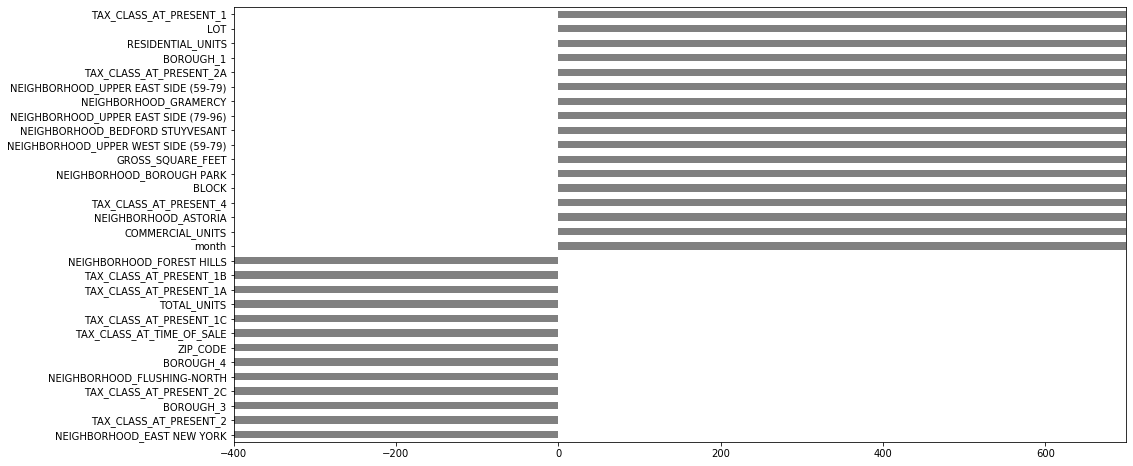

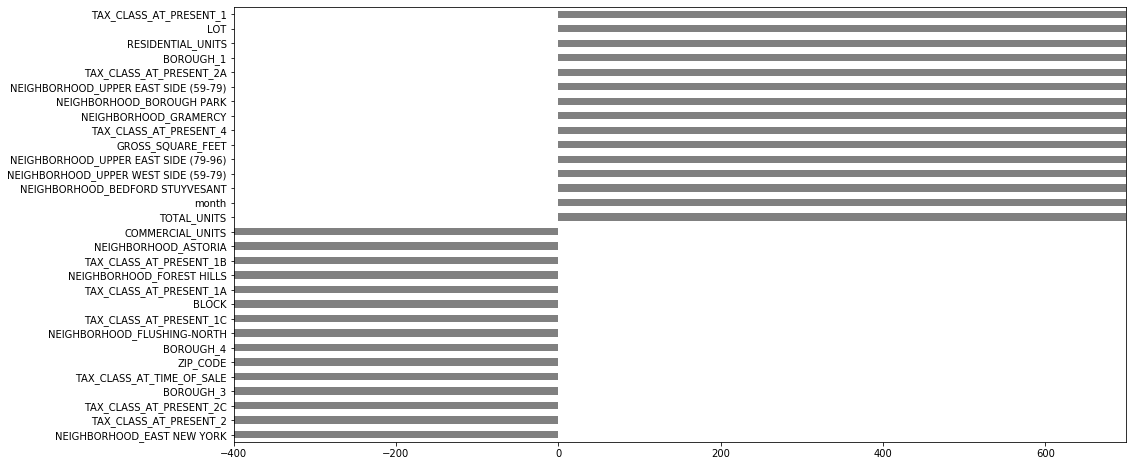

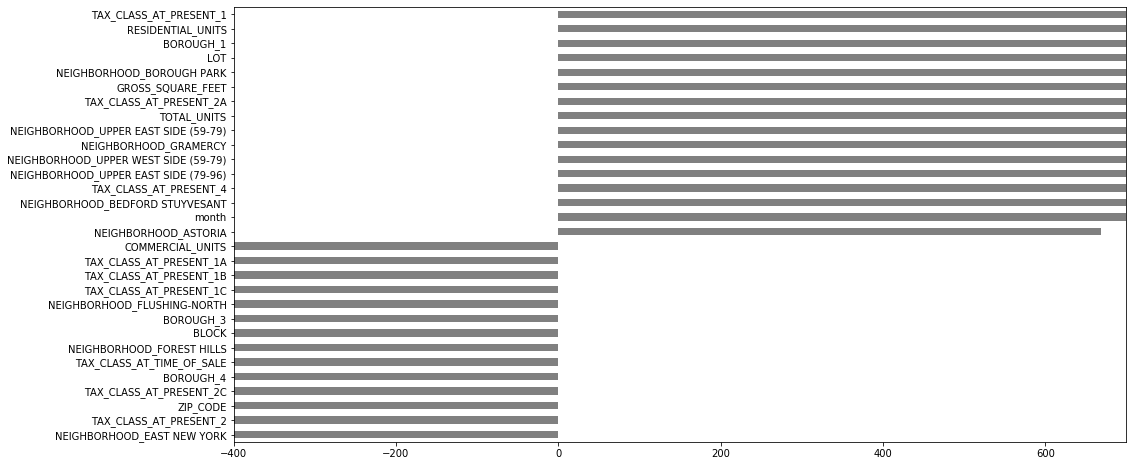

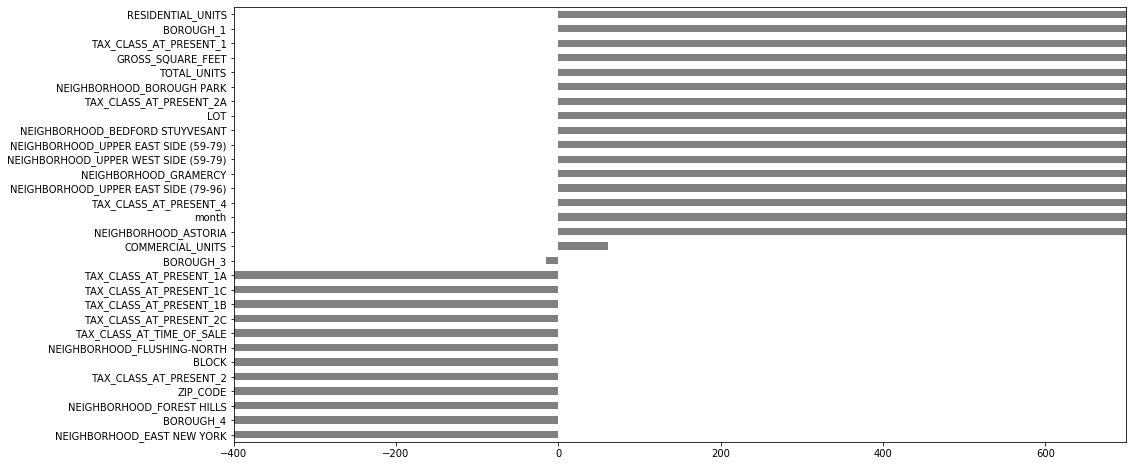

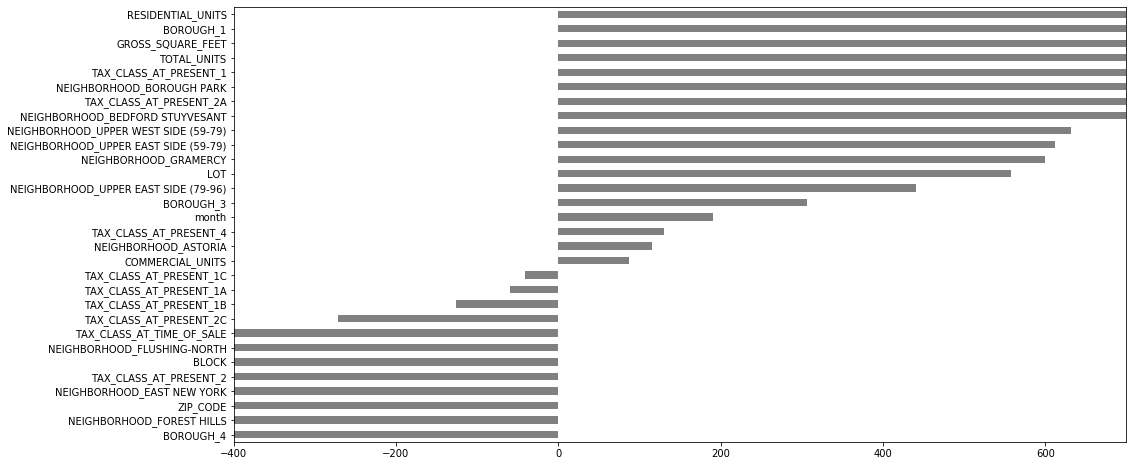

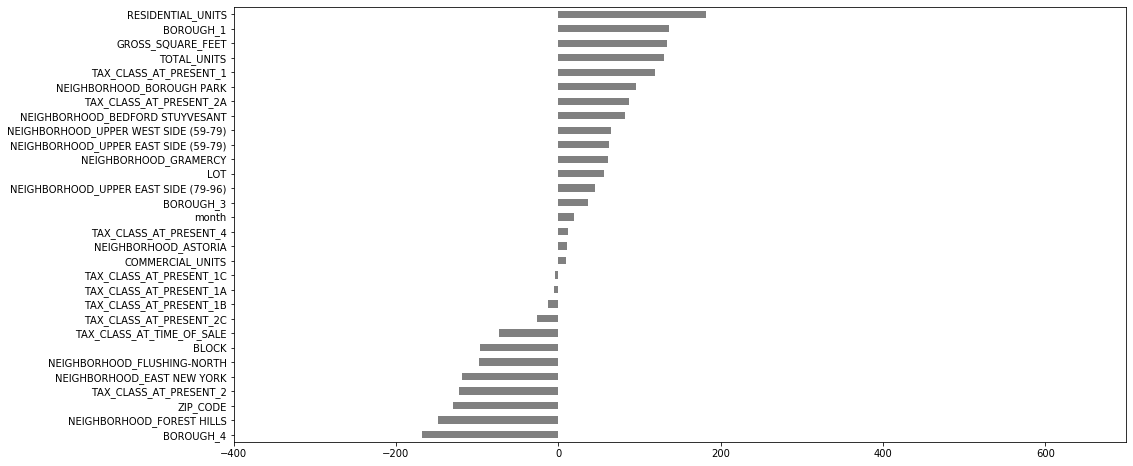

In [37]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))

    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()

In [55]:
from sklearn.metrics import mean_squared_error

alphas = []
mses = []

for alpha in range(0, 200, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)

0 8.05666864244033e+33
1 209858727405.11234
2 207433570420.53983
3 205323172317.1064
4 203539101299.3377
5 202028850497.99567
6 200742422676.524
7 199639005507.86307
8 198686200907.62506
9 197858332392.44516
10 197134930554.64886
11 196499544093.87405
12 195938837468.58734
13 195441910395.9833
14 194999782844.92252
15 194605002403.2216
16 194251342315.3844
17 193933567137.9117
18 193647249243.27106
19 193388623907.6233
20 193154473941.77777
21 192942037143.2999
22 192748931526.53677
23 192573094513.12112
24 192412733168.36093
25 192266283239.79443
26 192132375257.01276
27 192009806331.88977
28 191897516587.91202
29 191794569369.60797
30 191700134555.005
31 191613474427.94077
32 191533931672.00903
33 191460919130.72256
34 191393911044.16562
35 191332435524.83868
36 191276068077.45273
37 191224426001.3428
38 191177163541.64636
39 191133967677.75693
40 191094554455.84406
41 191058665787.24188
42 191026066646.8775
43 190996542616.14505
44 190969897723.12888
45 190945952540.16257
46 1909245

In [0]:
alphas = alphas[1:]
mses = mses[1:]

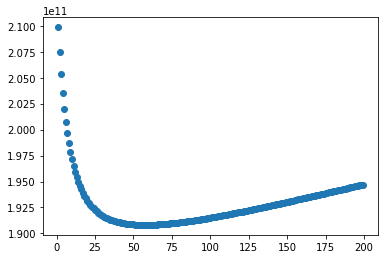

In [62]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(alphas, mses);